In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [317]:
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([200, 2])
    Xiin1 = np.zeros([200, 2])
    Piin1 = np.zeros([200, 2 , 2])
    Pii = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(1, len(X)):
        Xiin1[i] = np.dot(F, Xii[i - 1].reshape(2, 1)).reshape(1, 2)
        Piin1[i] = np.dot(np.dot(F, Pii[i - 1]), F.transpose()) + Q

        K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)

        Xii[i] = Xiin1[i] + K[i] * (z[i] - np.dot(H, Xiin1[i]))
        Pii[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(Piin1[i])
        
    return Xii, Pii, Piin1, K
        
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr

def backward_smooth(Xii, F, Pii, Piin1):
    x = np.array(Xii)
    Pn = np.array(Pii)
    A = np.zeros([200, 2, 2])
    for i in range(len(x) - 2, -1, -1):
        A[i] = (Pii[i].dot(F.transpose())).dot(np.linalg.inv(Piin1[i]))
        x[i] = Xii[i] + A[i].dot(x[i + 1] - F.dot(Xii[i]))
        Pn[i] = Pii[i] + (A[i].dot(Pn[i + 1] - Piin1[i])).dot(A[i].transpose())
    return x, Pn

In [318]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])
z = np.zeros(200)
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
for i in range(len(x)):
    z[i] = np.dot(H, X[i]) + eta[i]
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
R = sigmaeta_2
X0 = np.array([5, 1])
P0 = np.array([[1000, 0], [0, 1000]])

In [319]:
X_filt, Pii, Piin1, K = kalman_filt(z, X0, P0, F, Q, R, H)
X_back, Pn = backward_smooth(X_filt, F, Pii, Piin1)

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_35235/4111586537.py:29: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


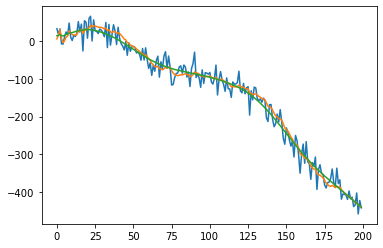

In [320]:
plt.plot(z)
plt.plot(X_filt[:, 0])
plt.plot(X_back[:, 0])
plt.show()

In [333]:
P = np.zeros([500, 200, 2, 2])
Pn1 = np.zeros([500, 200, 2, 2])
Pn = np.zeros([500, 200, 2, 2])
P_res = np.zeros([200, 2, 2])
P_resn1 = np.zeros([200, 2, 2])
P_resn = np.zeros([200, 2, 2])
err = np.zeros([500, 197, 2])
err_sm = np.zeros([500, 197, 2])
P0 = np.array([[10000, 0], [0, 10000]])
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    for k in range(len(x)):
        z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i], Pn1[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:3]
    X_smooth, Pn[i] = backward_smooth(X_filt, F, P[i], Pn1[i])
    
    err[i] = np.array(X[3:] - X_filt[3:]) ** 2
    err_sm[i] = np.array(X[3:] - X_smooth[3:]) ** 2
final_err = np.zeros([197, 2])
final_err_smooth = np.zeros([197, 2])
for i in range(197):
    final_err[i] = (np.mean(err[:, i])) ** 0.5
for i in range(197):
    final_err_smooth[i] = (np.mean(err_sm[:, i])) ** 0.5
for i in range(200):
    P_res[i] = np.mean(P[:,i])
for i in range(200):
    P_resn1[i] = np.mean(Pn1[:,i])
for i in range(200):
    P_resn[i] = np.mean(Pn[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_35235/4111586537.py:29: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


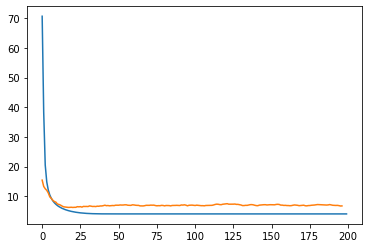

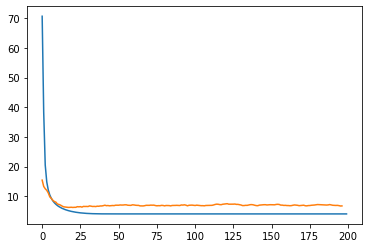

In [334]:
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(final_err[:, 0])
plt.show()
plt.plot(P_res[:, 1, 1] ** 0.5)
plt.plot(final_err[:, 1])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_35235/1170595240.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(P_resn[:, 0, 0] ** 0.5)


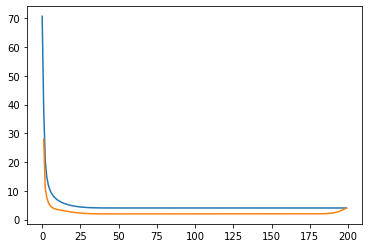

In [336]:
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(P_resn[:, 0, 0] ** 0.5)